In [1]:
import os
import numpy as np
import tensorflow as tf
import rasterio
import matplotlib.pyplot as plt
from glob import glob
from rasterio.plot import show
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.metrics import MeanIoU
from tensorflow import keras

In [3]:
# Paths to images and labels
data_dir = r"C:\Users\Eman\Downloads\images-20250217T060743Z-001\images"
labels_dir = r"C:\Users\Eman\Downloads\labels-20250217T060744Z-001\labels"


In [5]:
# Load TIFF images (12-band) and apply min-max normalization
def load_image(image_path):
    with rasterio.open(image_path) as src:
        image = src.read().astype(np.float32)  # Shape: (12, 128, 128)
        image = np.transpose(image, (1, 2, 0))  # Convert to (128, 128, 12)

    # Min-max normalization per channel
    min_val = np.min(image, axis=(0, 1), keepdims=True)
    max_val = np.max(image, axis=(0, 1), keepdims=True)
    
    # Avoid division by zero
    normalized_image = (image - min_val) / (max_val - min_val + 1e-7)
    
    return normalized_image


In [7]:
# Normalize label images
def load_label(label_path):
    label = tf.keras.preprocessing.image.load_img(label_path, color_mode="grayscale")
    label = np.array(label, dtype=np.uint8)  # Convert to numpy array
    label = (label > 0).astype(np.int32)  # Ensure binary format
    return label


In [9]:
# Get sorted lists of image and label file paths
image_paths = sorted(glob(os.path.join(data_dir, "*.tif")))
label_paths = sorted(glob(os.path.join(labels_dir, "*.png")))


In [11]:
# Split dataset into training and testing
train_images, test_images, train_labels, test_labels = train_test_split(
    image_paths, label_paths, test_size=0.2, random_state=42
)

In [13]:
# Prepare dataset for training
def preprocess_data(image_paths, label_paths):
    images = np.array([load_image(p) for p in image_paths])
    labels = np.array([load_label(p) for p in label_paths])
    labels = np.expand_dims(labels, axis=-1)  # Add channel dimension
    return images, labels

train_images_np, train_labels_np = preprocess_data(train_images, train_labels)
test_images_np, test_labels_np = preprocess_data(test_images, test_labels)
train_labels_np = tf.image.resize(train_labels_np, (64, 64))
test_labels_np = tf.image.resize(test_labels_np, (64, 64))

C:\Users\Eman\anaconda3\Lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [15]:
# Fine-Tune a Pretrained Model (ResNet50 as Encoder)
def build_finetuned_unet(input_shape=(128, 128, 12)):
    # Load a pre-trained ResNet50 encoder
    base_model = ResNet50(input_shape=(128, 128, 3), include_top=False, weights="imagenet")

    # Extend it to 12-band images using Conv2D
    input_layer = layers.Input(shape=input_shape)
    processed_input = layers.Conv2D(3, (1, 1), activation="relu", padding="same")(input_layer)  # Reduce bands to 3

    # Pass through pre-trained encoder
    encoder_output = base_model(processed_input)

    # Decoder with upsampling layers
    x = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding="same", activation="relu")(encoder_output)
    x = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same", activation="relu")(x)
    ##x = layers.Dropout(0.5)(x)
    x = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same", activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding="same", activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    output_layer = layers.Conv2D(1, (1, 1), activation="sigmoid")(x)

    # Build model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Freeze encoder for initial training
    for layer in base_model.layers[:100]:
        layer.trainable = False

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    return model


In [17]:
# Initialize and train the model
finetuned_model = build_finetuned_unet()
finetuned_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 12)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 3)         │              39 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 4, 4, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 256)           │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 1)           │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,693,928 (109.46 MB)

 Trainable params: 24,559,144 (93.69 MB)

 Non-trainable params: 4,134,784 (15.77 MB)

In [19]:

# Train the model with fine-tuning
finetuned_model.fit(train_images_np, train_labels_np, epochs=30, batch_size=8, validation_data=(test_images_np, test_labels_np))


Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 53s 864ms/step - accuracy: 0.5255 - loss: 0.6796 - val_accuracy: 0.7599 - val_loss: 0.6471
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 34s 633ms/step - accuracy: 0.6801 - loss: 0.5749 - val_accuracy: 0.7599 - val_loss: 0.5931
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 569ms/step - accuracy: 0.6780 - loss: 0.5452 - val_accuracy: 0.7599 - val_loss: 0.5478
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 849ms/step - accuracy: 0.7071 - loss: 0.4867 - val_accuracy: 0.7599 - val_loss: 0.5876
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 41s 846ms/step - accuracy: 0.7098 - loss: 0.5092 - val_accuracy: 0.7599 - val_loss: 0.6260
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 853ms/step - accuracy: 0.7083 - loss: 0.4394 - val_accuracy: 0.7599 - val_loss: 0.5173
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 851ms/step - accuracy: 0.7082 - loss: 0.4399 - val_accuracy: 0.7599 - val_loss: 1.1172
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 849ms/step - accuracy: 0.6929 - loss: 0.4614 - val_accu

In [21]:
# Custom IoU metric
def iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.int32)
    y_true = tf.cast(y_true, tf.int32)

    intersection = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    union = tf.reduce_sum(tf.cast(y_true + y_pred, tf.float32)) - intersection
    iou = (intersection + 1e-7) / (union + 1e-7)
    return iou

# Custom F1-score metric
def f1_score_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.int32)
    y_true = tf.cast(y_true, tf.int32)

    tp = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32))
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32))

    precision = tp / (tp + fp + 1e-7)
    recall = tp / (tp + fn + 1e-7)

    f1 = 2 * (precision * recall) / (precision + recall + 1e-7)
    return f1

In [23]:
# Unfreeze some encoder layers and continue fine-tuning
for layer in finetuned_model.layers[:70]:
    layer.trainable = True

finetuned_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
                        loss="binary_crossentropy",
                        metrics=["accuracy", iou_metric, f1_score_metric])

finetuned_model.fit(train_images_np, train_labels_np, epochs=30, batch_size=8, validation_data=(test_images_np, test_labels_np))


Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.8111 - f1_score_metric: 0.6383 - iou_metric: 0.4761 - loss: 0.3635 - val_accuracy: 0.7601 - val_f1_score_metric: 0.1273 - val_iou_metric: 0.0688 - val_loss: 4.5775
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 901ms/step - accuracy: 0.8144 - f1_score_metric: 0.6787 - iou_metric: 0.5284 - loss: 0.3787 - val_accuracy: 0.7636 - val_f1_score_metric: 0.1805 - val_iou_metric: 0.1009 - val_loss: 2.7229
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 894ms/step - accuracy: 0.8144 - f1_score_metric: 0.6771 - iou_metric: 0.5181 - loss: 0.3653 - val_accuracy: 0.7745 - val_f1_score_metric: 0.2476 - val_iou_metric: 0.1451 - val_loss: 1.7026
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 897ms/step - accuracy: 0.7908 - f1_score_metric: 0.6307 - iou_metric: 0.4708 - loss: 0.4355 - val_accuracy: 0.7606 - val_f1_score_metric: 0.2996 - val_iou_metric: 0.1810 - val_loss: 1.1824
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 917ms/step - accuracy: 0.8190 - f1_s

In [25]:
# Evaluate model performance
def evaluate_model(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.cast(y_pred, tf.int32)
    
    iou = MeanIoU(num_classes=2)
    iou.update_state(y_true, y_pred)
    
    precision = tf.keras.metrics.Precision()
    precision.update_state(y_true, y_pred)
    
    recall = tf.keras.metrics.Recall()
    recall.update_state(y_true, y_pred)
    
    f1_score = 2 * (precision.result().numpy() * recall.result().numpy()) / \
               (precision.result().numpy() + recall.result().numpy() + 1e-7)
    
    print(f"IoU: {iou.result().numpy():.4f}, Precision: {precision.result().numpy():.4f}, "
          f"Recall: {recall.result().numpy():.4f}, F1-score: {f1_score:.4f}")

# Predict and evaluate
predictions = (finetuned_model.predict(test_images_np) > 0.5).astype(np.int32)
evaluate_model(test_labels_np, predictions)

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
IoU: 0.6371, Precision: 0.5551, Recall: 0.7938, F1-score: 0.6534


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


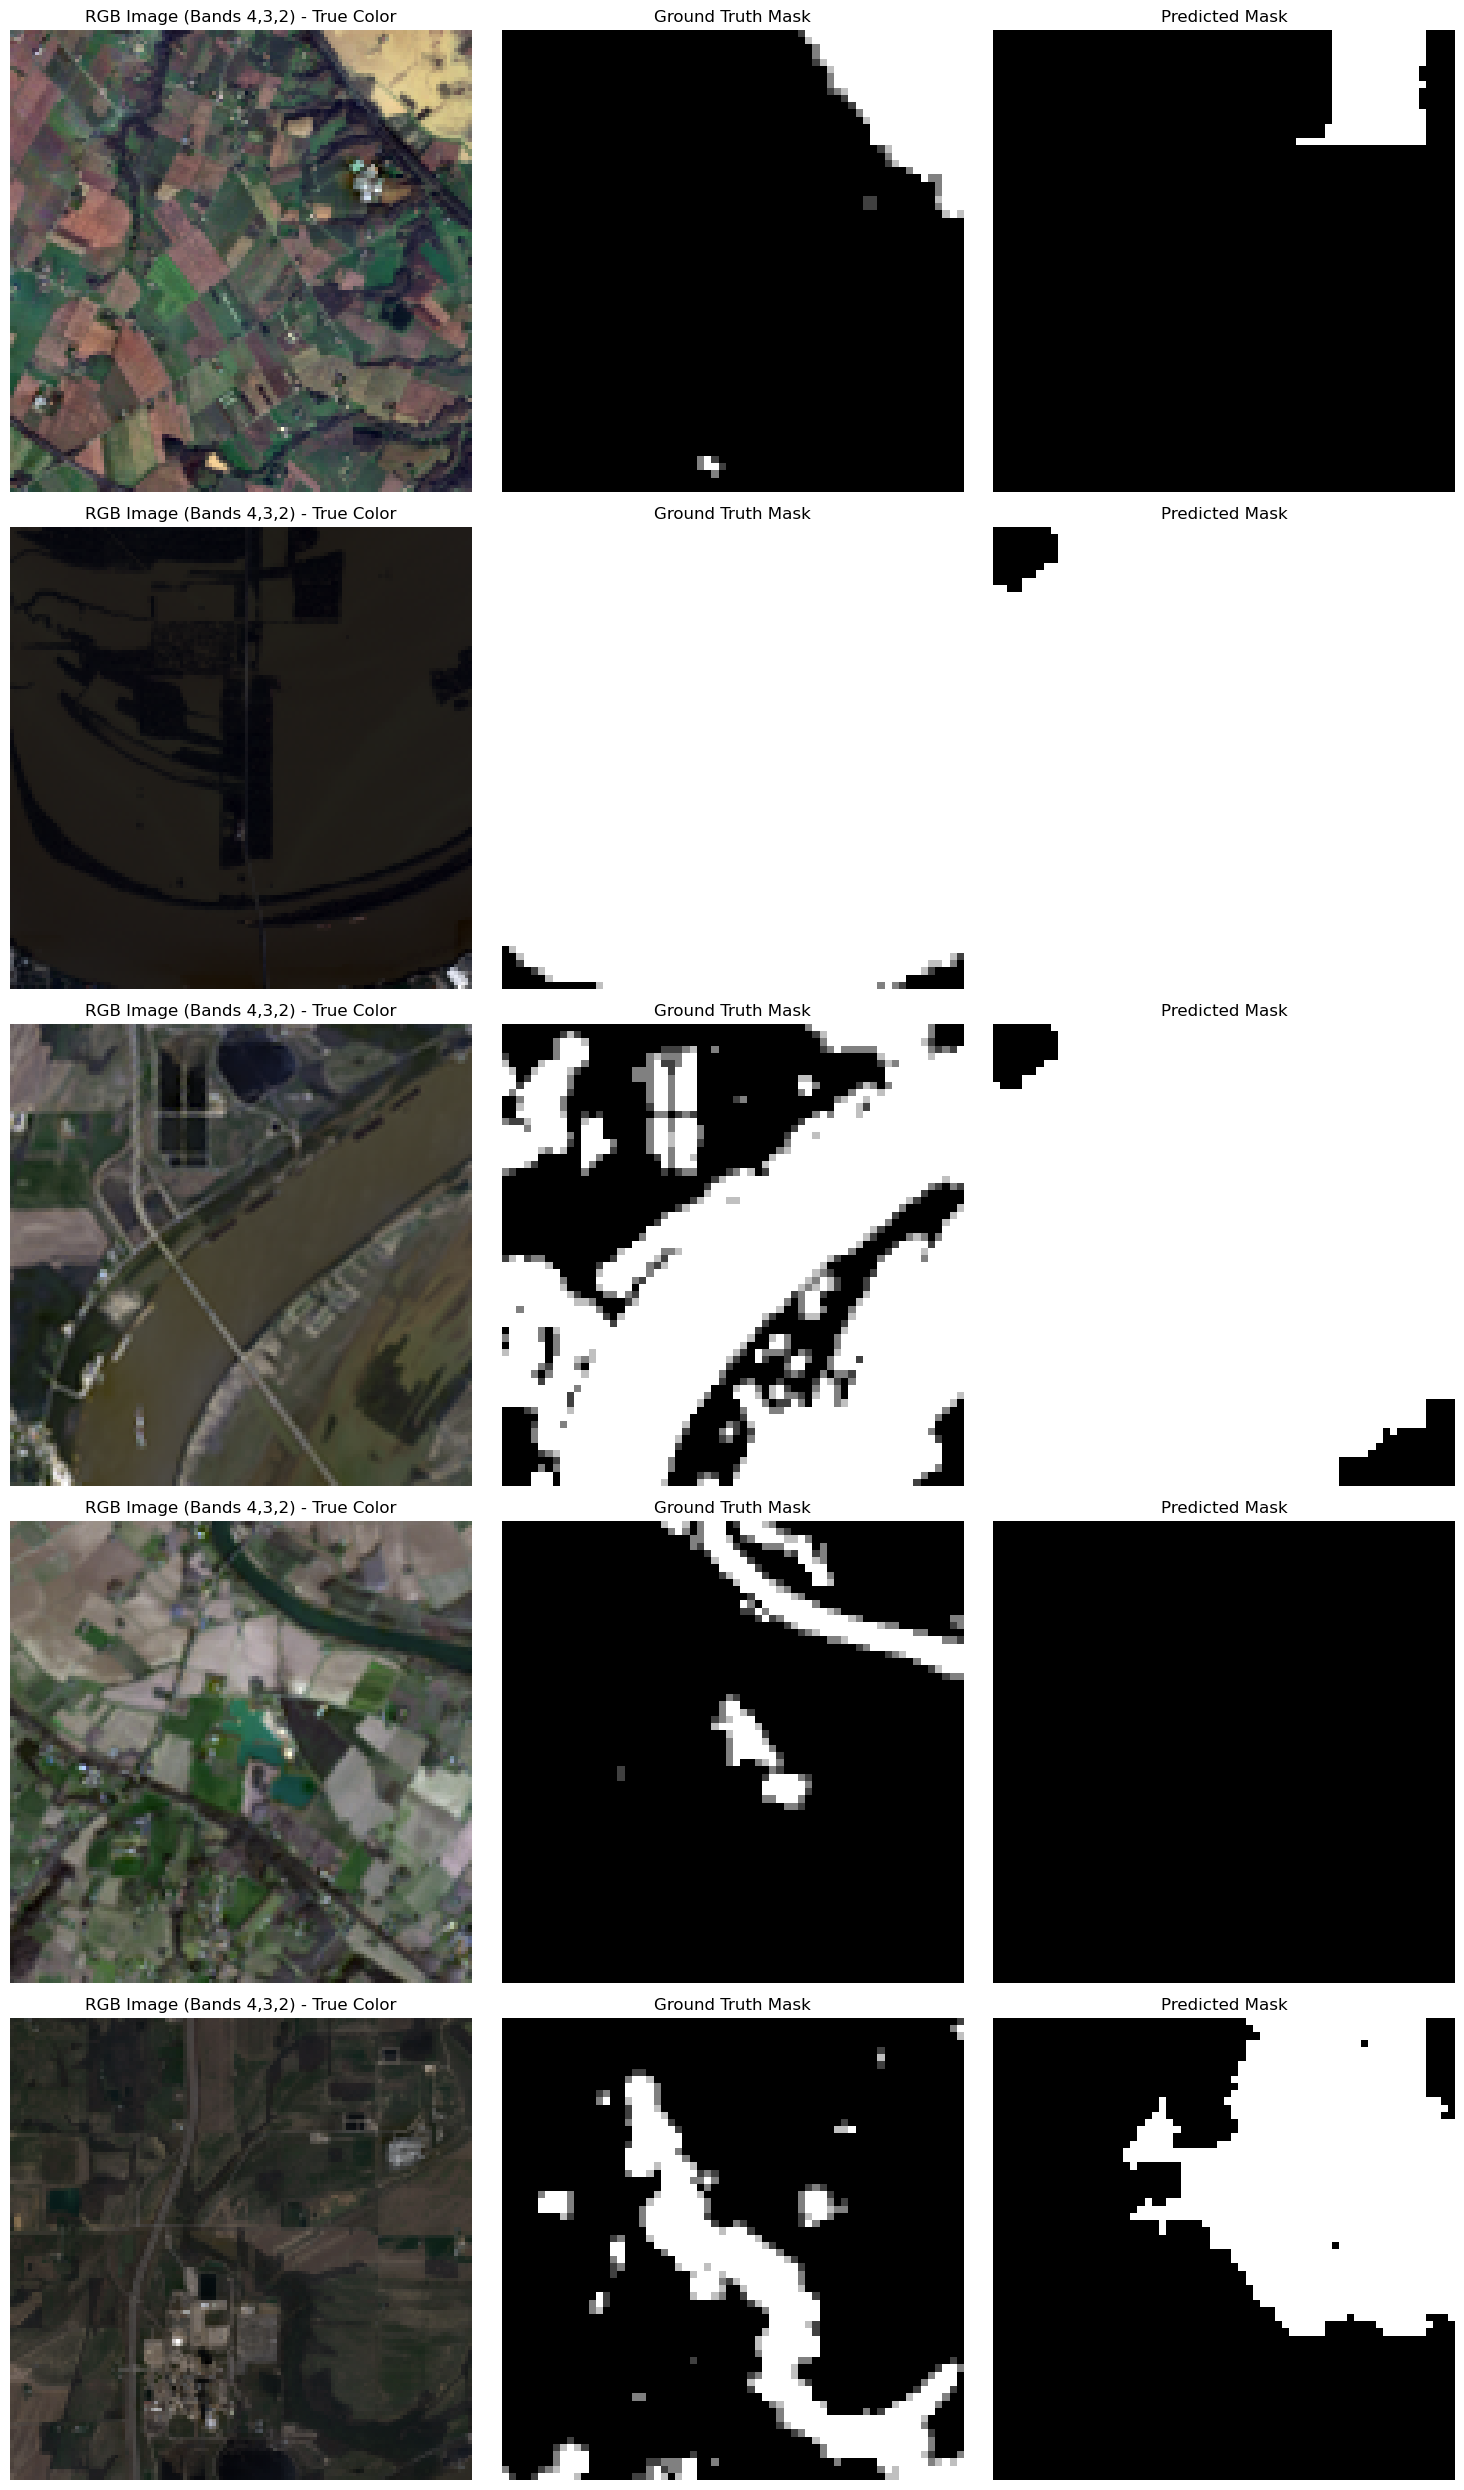

In [37]:
# Function to visualize RGB + ground truth + predictions
import os 
import numpy as np
import matplotlib.pyplot as plt
import random

def visualize_predictions_rgb(model, X_test, Y_test, num_samples=5, rgb_bands=(4, 3, 2)):
    plt.figure(figsize=(15, num_samples * 5))
    indices = random.sample(range(len(X_test)), num_samples)
    for i, idx in enumerate(indices):
        img = X_test[idx]
        true_mask = Y_test[idx]
        rgb_image = img[..., [rgb_bands[0]-1, rgb_bands[1]-1, rgb_bands[2]-1]]
        rgb_image = np.clip((rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min()), 0, 1)
        pred_mask = model.predict(img[np.newaxis, ...])[0, ..., 0]
        pred_mask = (pred_mask > 0.5).astype(np.uint8)
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(rgb_image)
        plt.title("RGB Image (Bands 4,3,2) - True Color")
        plt.axis("off")
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(true_mask, cmap="gray", vmin=0, vmax=1)
        plt.title("Ground Truth Mask")
        plt.axis("off")
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(pred_mask, cmap="gray", vmin=0, vmax=1)
        plt.title("Predicted Mask")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

visualize_predictions_rgb(finetuned_model, test_images_np, test_labels_np, rgb_bands=(4, 3, 2))
